# import imprortant library


In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import cv2.cuda
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from PIL import Image
from keras.utils import to_categorical
import torch
import warnings
warnings.filterwarnings('ignore')
import torchvision.models as models
from keras.utils import to_categorical
from sklearn.model_selection import KFold 
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import torch.nn as nn
from typing import Any, List
import torchvision
from torch import optim , autocast
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import cv2
from torch.cuda.amp import GradScaler
from torchvision import transforms, datasets
from collections import Counter
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torchmetrics
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
test_X = torch.load('test_X.pt')
test_Y = torch.load('test_Y.pt')

In [3]:
print("Wafer Tensors Shape:", test_X.shape)
print("Label Tensors Shape:", test_Y.shape)

Wafer Tensors Shape: torch.Size([73714, 3, 56, 56])
Label Tensors Shape: torch.Size([73714, 1, 36])


In [4]:
args = {"BATCH_SIZE": 512, "LEARNING_RATE": 5e-4, "NUM_EPOCH": 100}

In [5]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

In [6]:
import torch.utils.data as data


class BasicDataset(data.Dataset):
    def __init__(self, x_tensor, y_tensor):
        super(BasicDataset, self).__init__()

        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [7]:
dataset_test = BasicDataset(test_X, test_Y)

In [8]:
class ResNet(nn.Module):
    def __init__(self, num_classes=36):
        super(ResNet, self).__init__()
        self.resnet  = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = x.float()
        x = self.resnet(x)
        return x

In [9]:
ResNet = ResNet().to(DEVICE)

In [10]:
ResNet.load_state_dict(torch.load('ResNet.pth'))

<All keys matched successfully>

In [11]:
ResNet.eval()

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [12]:
testloader = DataLoader(dataset_test, batch_size=args["BATCH_SIZE"])

In [13]:
y_pred = []
y_true = []
# iterate over test data
for images, labels in testloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE).squeeze()
        output = ResNet(images) # Feed Network
        y_pred.extend(output.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())


In [14]:
classes = ['C+EL', 'C+EL+L', 'C+EL+S', 'C+ER', 'C+ER+L', 'C+ER+S', 'C+L',
       'C+L+EL+S', 'C+L+ER+S', 'C+L+S', 'C+S', 'Center', 'D+EL', 'D+EL+L',
       'D+EL+S', 'D+ER', 'D+ER+L', 'D+ER+S', 'D+L', 'D+L+EL+S',
       'D+L+ER+S', 'D+L+S', 'D+S', 'Donut', 'EL+L', 'EL+L+S', 'EL+S',
       'ER+L', 'ER+S', 'Edge-Loc', 'Edge-Ring', 'L+S', 'Loc', 'Near-full',
       'Random', 'Scratch']
label_dict = {class_name: i for i, class_name in enumerate(classes)}
y_true_ = np.argmax(y_true, axis=1)
y_pred_ = np.argmax(y_pred, axis=1)

In [15]:
y_true_one_hot = label_binarize(y_true_, classes=list(range(len(classes))))
y_pred_one_hot = label_binarize(y_pred_, classes=list(range(len(classes))))

In [16]:
y_pred_one_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

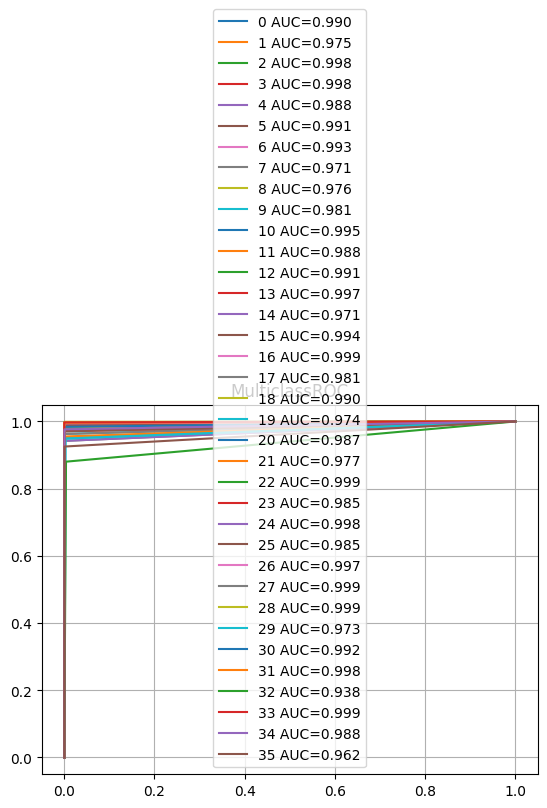

In [17]:
from torchmetrics.classification import MulticlassROC
metric = MulticlassROC(num_classes=36)
metric.update(torch.tensor(y_pred_one_hot).float() ,torch.tensor(y_true_))
fig_, ax_ = metric.plot(score=True)

Class C+EL (AUC = 0.99)
Class C+EL+L (AUC = 0.98)
Class C+EL+S (AUC = 0.99)
Class C+ER (AUC = 0.98)
Class C+ER+L (AUC = 0.97)
Class C+ER+S (AUC = 0.99)
Class C+L (AUC = 0.98)
Class C+L+EL+S (AUC = 0.99)
Class C+L+ER+S (AUC = 0.99)
Class C+L+S (AUC = 0.99)
Class C+S (AUC = 1.00)
Class Center (AUC = 0.98)
Class D+EL (AUC = 0.98)
Class D+EL+L (AUC = 0.99)
Class D+EL+S (AUC = 0.99)
Class D+ER (AUC = 0.98)
Class D+ER+L (AUC = 0.99)
Class D+ER+S (AUC = 0.98)
Class D+L (AUC = 0.99)
Class D+L+EL+S (AUC = 0.99)
Class D+L+ER+S (AUC = 0.99)
Class D+L+S (AUC = 0.98)
Class D+S (AUC = 1.00)
Class Donut (AUC = 0.99)
Class EL+L (AUC = 1.00)
Class EL+L+S (AUC = 1.00)
Class EL+S (AUC = 0.99)
Class ER+L (AUC = 0.99)
Class ER+S (AUC = 1.00)
Class Edge-Loc (AUC = 0.95)
Class Edge-Ring (AUC = 0.99)
Class L+S (AUC = 1.00)
Class Loc (AUC = 0.93)
Class Near-full (AUC = 1.00)
Class Random (AUC = 0.99)
Class Scratch (AUC = 0.99)


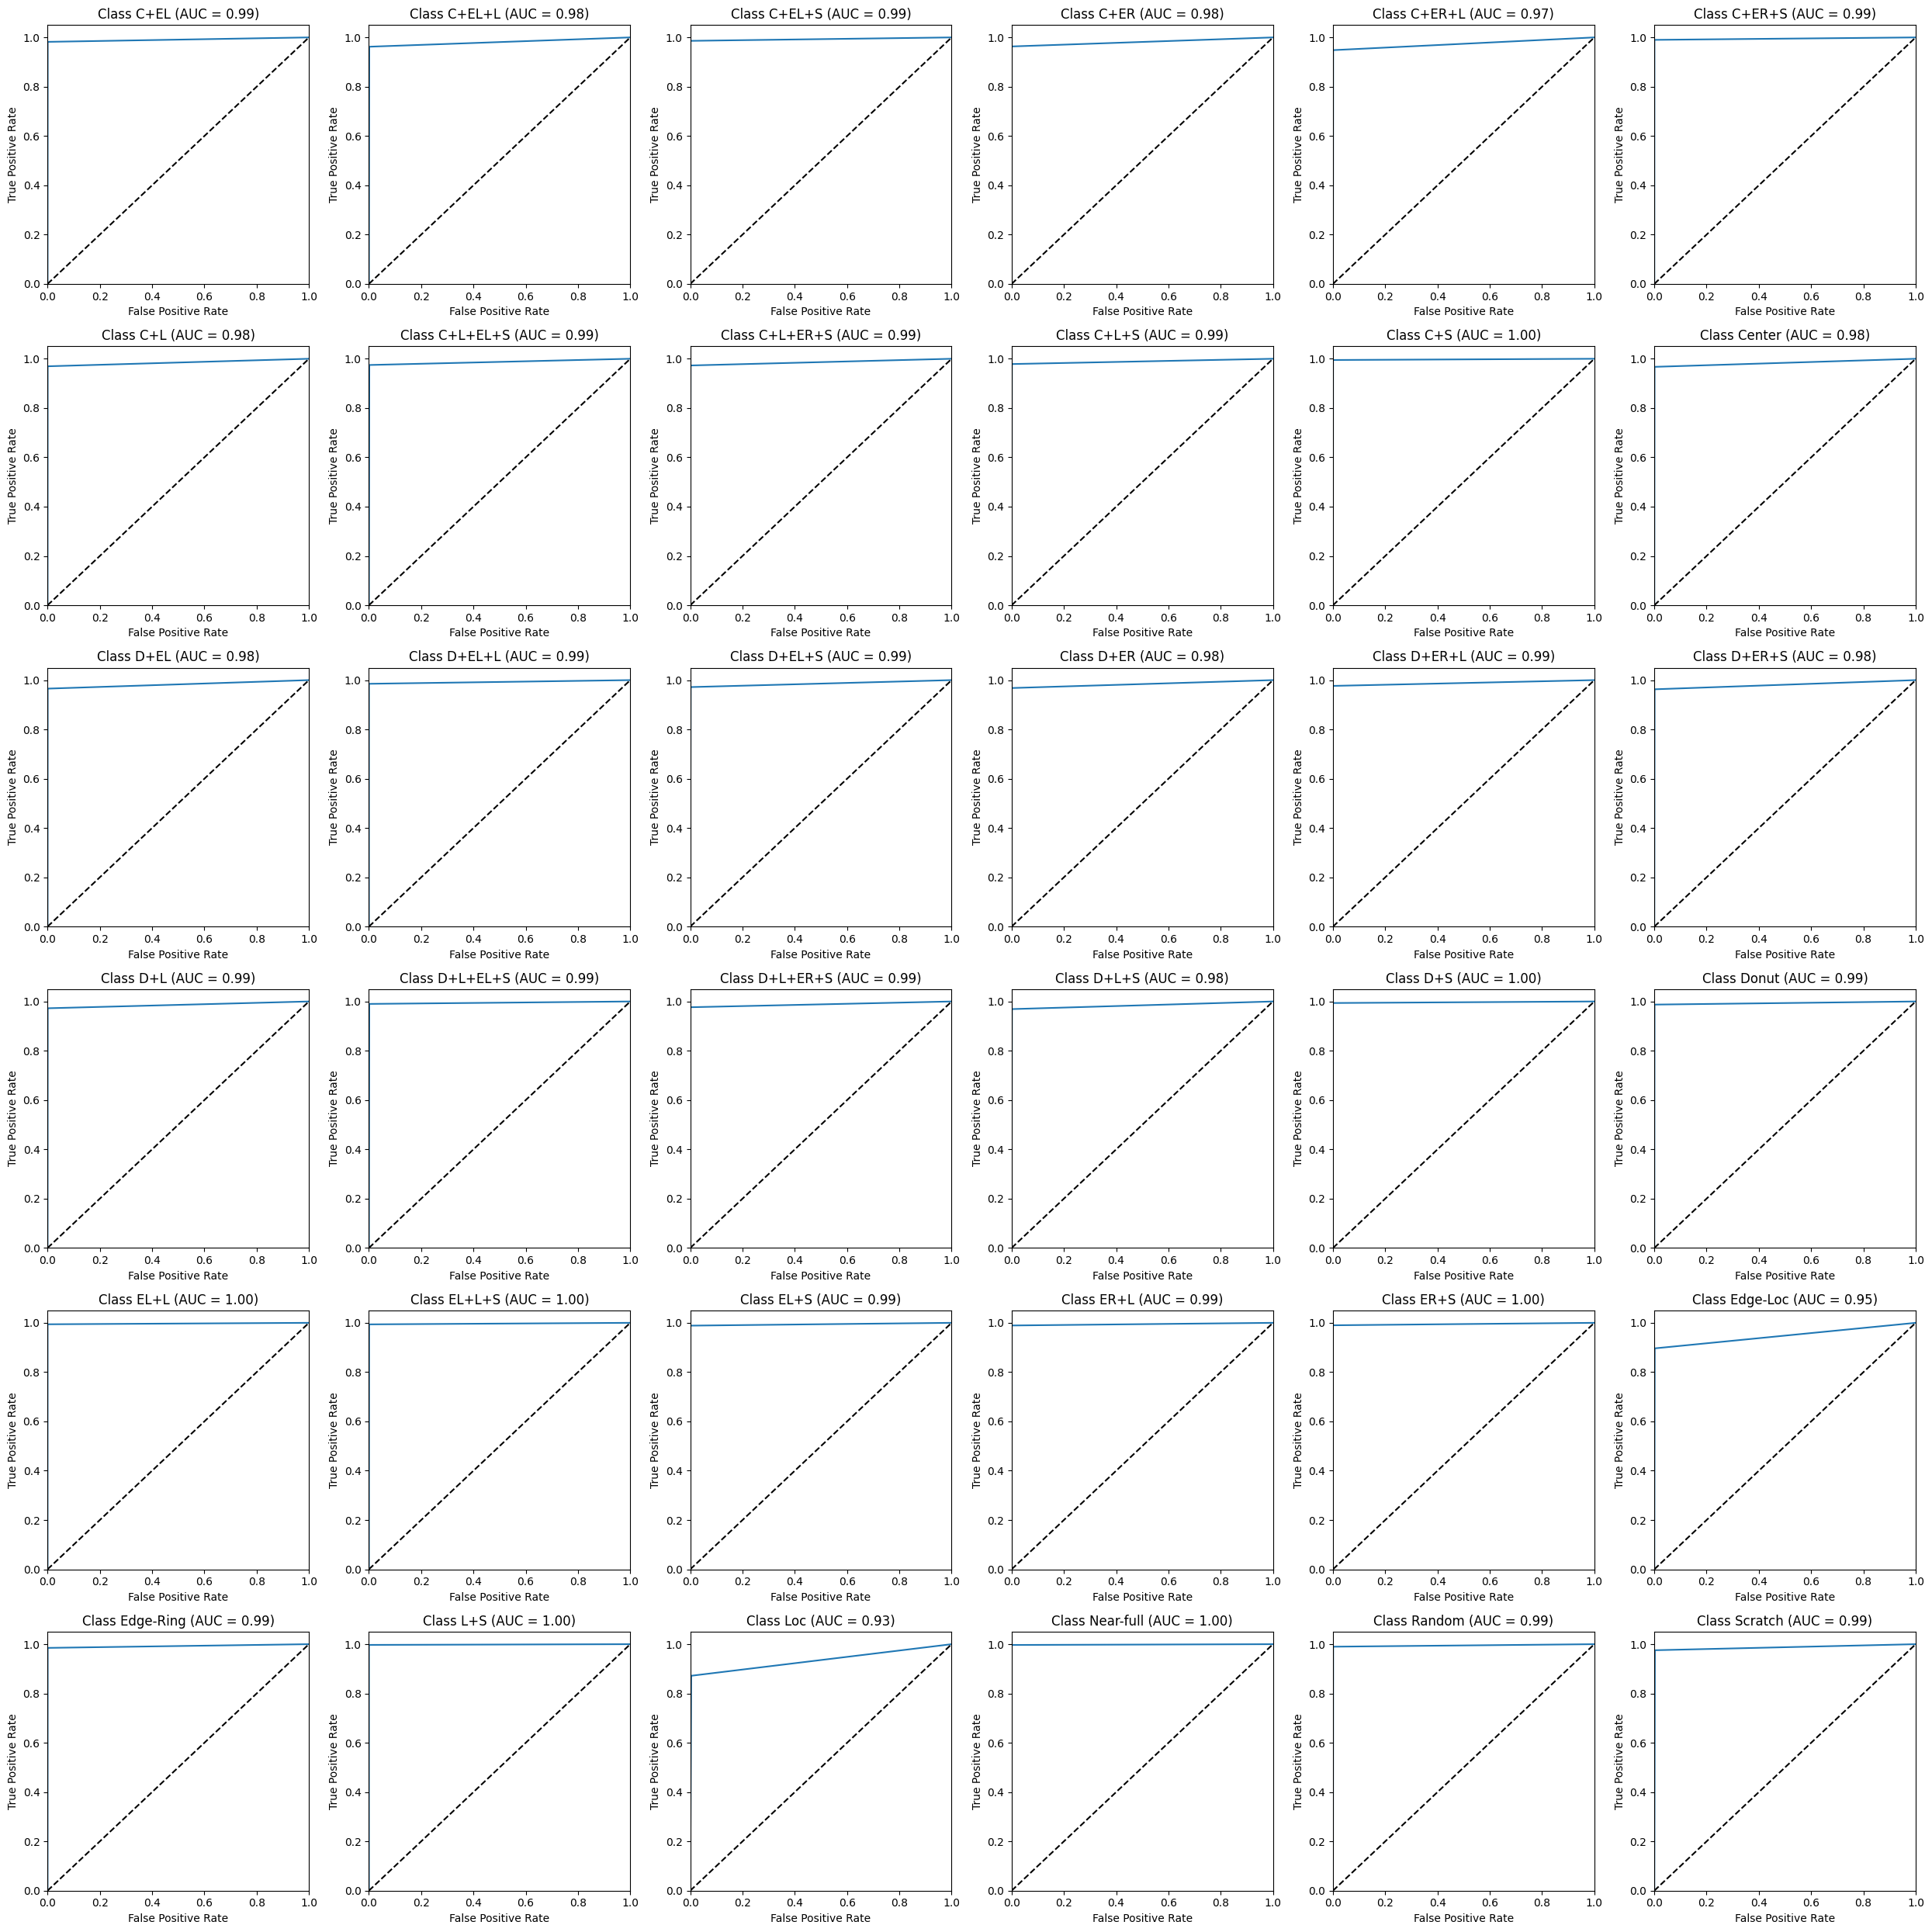

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(y_pred_one_hot[:, i], y_true_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create a grid of subplots
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(25, 25))

# Plot each ROC curve in a separate subplot
for i in range(36):
    row = i // 6
    col = i % 6
    axs[row, col].plot(fpr[i], tpr[i])
    axs[row, col].plot([0, 1], [0, 1], 'k--')
    axs[row, col].set_xlim([0.0, 1.0])
    axs[row, col].set_ylim([0.0, 1.05])
    axs[row, col].set_xlabel('False Positive Rate')
    axs[row, col].set_ylabel('True Positive Rate')
    axs[row, col].set_title('Class %s (AUC = %0.2f)' % (classes[i], roc_auc[i]))
    print('Class %s (AUC = %0.2f)' % (classes[i], roc_auc[i]))

plt.tight_layout()
plt.show()

In [19]:
y_pred_one_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
cf_matrix = confusion_matrix(y_true_,y_pred_)

In [21]:
cf_matrix.data


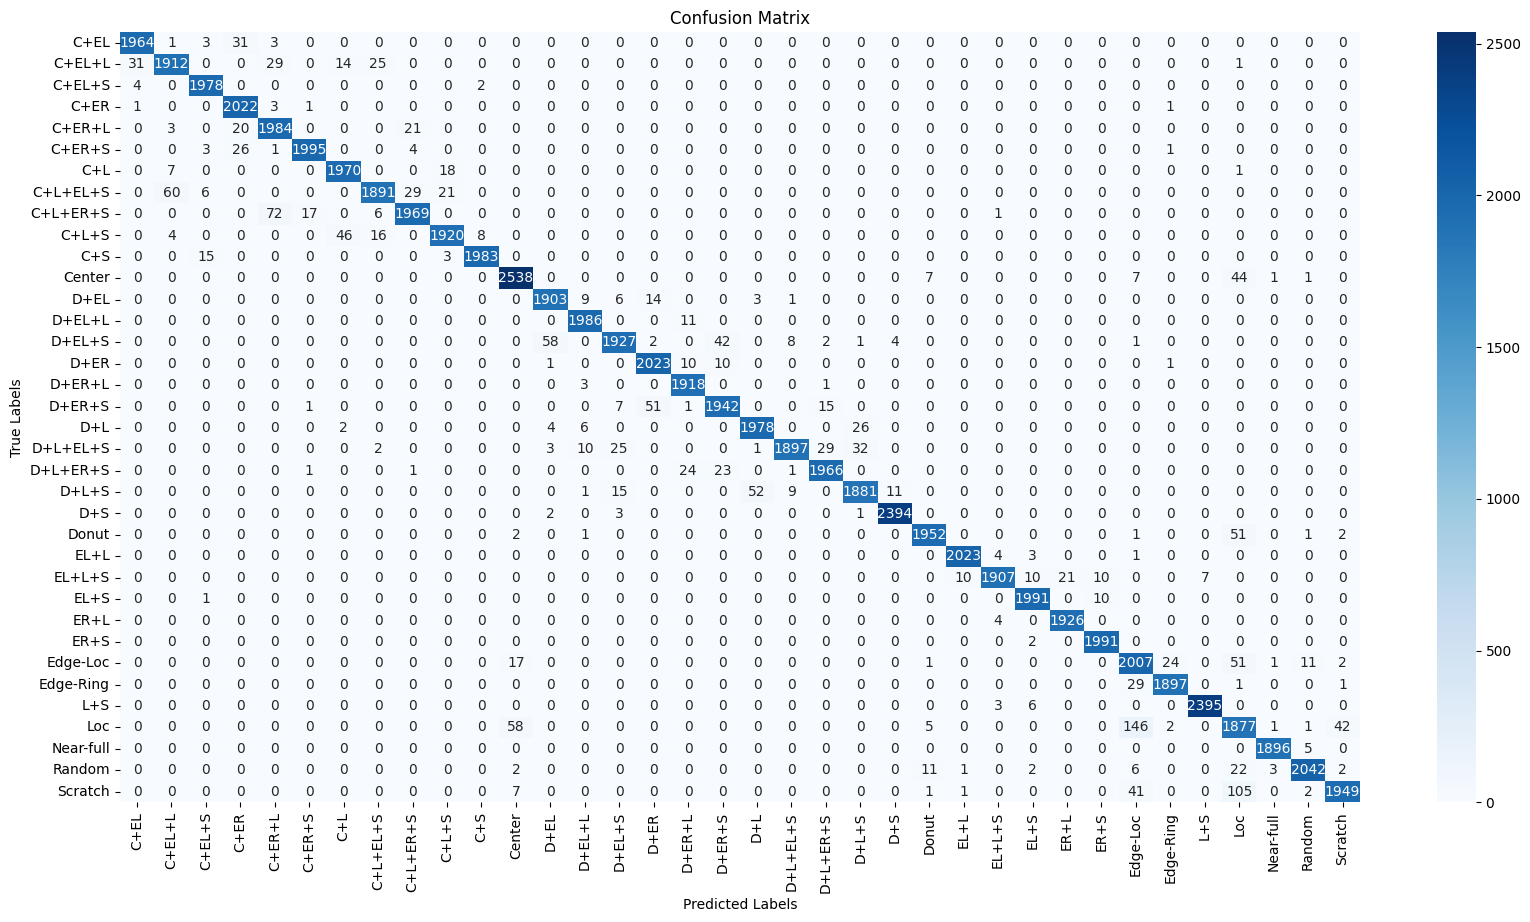

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels


# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [23]:
TP = cf_matrix[1][1]
TN = cf_matrix[0][0]
FP = cf_matrix[0][1]
FN = cf_matrix[1][0]

print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)

TP: 1912
TN: 1964
FP: 1
FN: 31


In [24]:
Accuracy, Precision, Recall, F1_score = [], [], [], []
TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - TP - FP - FN
for i, class_name in enumerate(classes):
    print(f'Class: {class_name}')
    print(f'TP: {TP[i]}')
    print(f'TN: {TN[i]}')
    print(f'FP: {FP[i]}')
    print(f'FN: {FN[i]}\n')
    accuracy = (TP[i] + TN[i]) / (TP[i] + TN[i] + FP[i] + FN[i])
    precision = TP[i] / (TP[i] + FP[i])
    recall = TP[i] / (TP[i] + FN[i])
    f1_score = 2 * precision * recall / (precision + recall)
    Accuracy.append(accuracy)
    Precision.append(precision)
    Recall.append(recall)
    F1_score.append(f1_score)
    
    print(f'Accuracy: {accuracy:.2f} Precision: {precision:.2f} Recall: {recall:.2f} F1 score: {f1_score:.2f}')


print("Accuracy: {:.3f}  Precision: {:.3f}  Recall: {:.2f}  F1_score: {:.2f}".format(np.mean(Accuracy), np.mean(Precision), np.mean(Recall), np.mean(F1_score)  ))

Class: C+EL
TP: 1964
TN: 71676
FP: 36
FN: 38

Accuracy: 1.00 Precision: 0.98 Recall: 0.98 F1 score: 0.98
Class: C+EL+L
TP: 1912
TN: 71627
FP: 75
FN: 100

Accuracy: 1.00 Precision: 0.96 Recall: 0.95 F1 score: 0.96
Class: C+EL+S
TP: 1978
TN: 71702
FP: 28
FN: 6

Accuracy: 1.00 Precision: 0.99 Recall: 1.00 F1 score: 0.99
Class: C+ER
TP: 2022
TN: 71609
FP: 77
FN: 6

Accuracy: 1.00 Precision: 0.96 Recall: 1.00 F1 score: 0.98
Class: C+ER+L
TP: 1984
TN: 71578
FP: 108
FN: 44

Accuracy: 1.00 Precision: 0.95 Recall: 0.98 F1 score: 0.96
Class: C+ER+S
TP: 1995
TN: 71664
FP: 20
FN: 35

Accuracy: 1.00 Precision: 0.99 Recall: 0.98 F1 score: 0.99
Class: C+L
TP: 1970
TN: 71656
FP: 62
FN: 26

Accuracy: 1.00 Precision: 0.97 Recall: 0.99 F1 score: 0.98
Class: C+L+EL+S
TP: 1891
TN: 71658
FP: 49
FN: 116

Accuracy: 1.00 Precision: 0.97 Recall: 0.94 F1 score: 0.96
Class: C+L+ER+S
TP: 1969
TN: 71594
FP: 55
FN: 96

Accuracy: 1.00 Precision: 0.97 Recall: 0.95 F1 score: 0.96
Class: C+L+S
TP: 1920
TN: 71678
FP: 42
